In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import squareform, pdist, euclidean
import math 

import sys
!{sys.executable} -m pip install kneed
from kneed import KneeLocator

# Functions

## Distance

In [ ]:
def reduce_dim(z):
    d_0 = 0
    d_1 = 0
    d_2 = 0
    d_3 = 0
    los_z = z[-1]
    los_windows = {0: list(range(14)), 0.5:list(range(14, 28)), 0.75:list(range(28, 62))}
    for k, l in los_windows.items():
        if los_z in l:
            d_0 = k
    
    prog_z = z[9:11]
    prog_windows = {0:[0,0], 1:[1, 0], 1.5:[0, 1], 1.5:[1, 1]}
    for k, l in prog_windows.items():
        if (prog_z[0] == l[0]) and (prog_z[1] == l[1]):
            d_1 = k
    
    oxy_z = z[11:-1]
    oxy_windows = {0:[0, 0], 0.75:[1, 0], 1:[0, 1], 1.25:[1, 1]}
    for k, l in oxy_windows.items():
        if (oxy_z[0] == l[0]) and (oxy_z[1] == l[1]):
            d_2 = k
            if oxy_z[2]:
                d_2 += 0.5
    
    if d_1 + d_2 == 0:
        #no other features except los
        chap_z = z[:9]
        weights = [0.5, 0.5, 0, 0.75, 0, 0, 0, 0.75, 0.5]
        d_3 = 0
        for c, w in zip(chap_z, weights):
            d_3 += c*w
    else:
        d_3 = 0
    
    return np.array([d_0, d_1, d_2, d_3])
    

In [ ]:
def similarity(x, y):
    x_d = reduce_dim(x)
    y_d = reduce_dim(y)
    return euclidean(x_d, y_d)

In [ ]:
def similarity_matrix(data):
    sim = pd.DataFrame(squareform(pdist(data, metric = similarity)), columns=data.index, index=data.index)
    return sim

## DBScan

In [ ]:
def chooseEps(sim, minPts = 10):
    neigh = NearestNeighbors(n_neighbors=minPts, n_jobs = -1, metric ='precomputed')
    neigh.fit(sim)
    dist, ind = neigh.kneighbors(sim)
    distances = [dist[i][minPts - 1] for i in range(len(dist))]
    plt.scatter(list(range(sim.shape[0])),sorted(distances))
    plt.show()
    kl = KneeLocator(list(range(sim.shape[0])), distances, curve="convex", direction="increasing")

    return kl.knee_y

In [ ]:
def tuneEps(sim, rangeEps, minPts = 10):
    for i in rangeEps:
        print('eps values is ' + str(i))
        db = DBSCAN(eps = i, min_samples = minPts, metric = 'precomputed').fit(sim)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        n_noise = list(labels).count(-1)
        print(set(labels))
        print("Silhouette Coefficient: %0.3f" % silhouette_score(sim, labels, metric = 'precomputed'))
        print('Estimated number of noise points: %d' % n_noise)

In [ ]:
def plotSilhouette(sim, n_clusters, labels):
# based on code from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(sim) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sim, labels, metric = 'precomputed')
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sim, labels, metric = 'precomputed')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(("Silhouette analysis for DBScan clustering on sample data with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.show()

In [ ]:
def applyDBScan(sim, eps, minPts = 10):
    db = DBSCAN(eps = eps, min_samples = minPts, metric = 'precomputed').fit(sim)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters)
    print('Estimated number of noise points: %d' % n_noise)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(sim, labels, metric = 'precomputed'))
    
    plotSilhouette(sim, n_clusters, labels)
    return labels

# Data

In [ ]:
disch_chaps = pd.read_csv('discharge_chapters_simple.csv', usecols = ['Blood/Immune', 'Circulatory', "Abnormal", "Musculoskeletal", "Genitourinary", "Nutritional", "Nervous", "Respiratory", "Digestive"]).applymap(lambda x:1 if x >= 1 else 0)
disch_chaps.head()

,Nervous,Abnormal,Musculoskeletal,Circulatory,Digestive,Nutritional,Genitourinary,Respiratory,Blood/Immune
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


In [ ]:
other_features = pd.read_csv('combined_clean.csv', usecols = ['id', 'ICU', 'death', 'Oxygen therapy - face mask', 'Oxygen therapy - high flow', 'Oxygen therapy - ventilator', 'Oxygen therapy - intubation', 'ECMO', 'Noninvasive ventilation', 'Invasive ventilation', 'Methylprednisolone', 'Norepinephrine', 'los']).fillna(0)
other_features.head()

,id,ICU,Oxygen therapy - face mask,Oxygen therapy - high flow,Oxygen therapy - ventilator,ECMO,Oxygen therapy - intubation,Norepinephrine,Noninvasive ventilation,Invasive ventilation,Methylprednisolone,death,los
0,100251,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,16.0
1,101019,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10.0
2,102696,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11.0
3,101588,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10.0
4,100358,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,19.0


In [ ]:
oxygen_therapies = pd.DataFrame(columns = ['Oxygen therapy - noninvasive', 'Oxygen therapy - invasive'])
oxygen_therapies['Oxygen therapy - noninvasive'] = (other_features['Oxygen therapy - face mask'] + other_features['Oxygen therapy - high flow'] + other_features['Noninvasive ventilation']) > 0
oxygen_therapies['Oxygen therapy - invasive'] = (other_features['Oxygen therapy - intubation'] + other_features['Oxygen therapy - ventilator'] + other_features['Invasive ventilation']) > 0
oxygen_therapies = oxygen_therapies.applymap(lambda x: 1 if x else 0)

In [ ]:
data = pd.concat([disch_chaps, other_features[['ICU', 'death']], oxygen_therapies, other_features[['ECMO', 'los']]], axis = 1)
data.head()

,Nervous,Abnormal,Musculoskeletal,Circulatory,Digestive,Nutritional,Genitourinary,Respiratory,Blood/Immune,ICU,death,Oxygen therapy - noninvasive,Oxygen therapy - invasive,ECMO,los
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,16.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,10.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,11.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,10.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,19.0


In [ ]:
sim = similarity_matrix(data)

<AxesSubplot:>

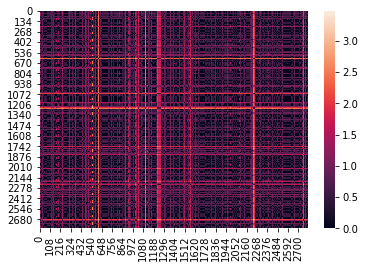

In [ ]:
sns.heatmap(sim)

In [ ]:
sim.max().max()

3.48209706929603

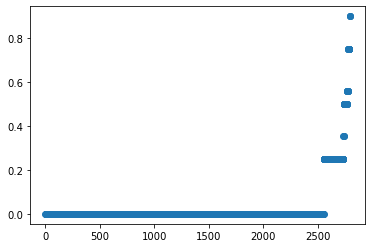

0.0

In [ ]:
chooseEps(sim, 16)

In [ ]:
tuneEps(sim, [0.1, 0.2, 0.3, 0.4, 0.45, 0.5], 16)

eps values is 0.1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
Silhouette Coefficient: 0.857
Estimated number of noise points: 241
eps values is 0.2
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
Silhouette Coefficient: 0.857
Estimated number of noise points: 241
eps values is 0.3
{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
Silhouette Coefficient: 0.832
Estimated number of noise points: 39
eps values is 0.4
{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
Silhouette Coefficient: 0.832
Estimated number of noise points: 37
eps values is 0.45
{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
Silhouette Coefficient: 0.832
Estimated number of noise points: 37
eps values is 0.5
{0, 1, 2, -1}
Silhouette Coefficient: 0.538
Estimated number of noise points: 2


Estimated number of clusters: 9
Estimated number of noise points: 37
Silhouette Coefficient: 0.832
For n_clusters = 9 The average silhouette_score is : 0.8315416635238834


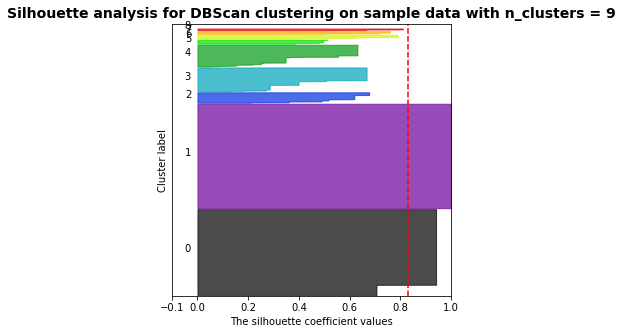

In [ ]:
clusters = applyDBScan(sim, 0.45, 16)

In [ ]:
id_nums = pd.read_csv('discharge_chapters_simple.csv', usecols = ['id'], squeeze = True).tolist()
dbscan_clusters = pd.DataFrame({'id':id_nums, 'clusters_9':clusters})
dbscan_clusters.to_csv('dbscan_clusters.csv')